<a href="https://colab.research.google.com/github/anquin129/NeuroAI/blob/main/ErrorDetect1dCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1D CNN Model for Error Detection with EEG Data

### Mount HDF5 file from Google Drive

In [ ]:
import h5py
import numpy as np
from google.colab import drive
import os # make dirs if needed

# Import Google Drive
drive.mount('/content/drive')
# Load file
h5_file_path = '/content/drive/MyDrive/ErrorDetectionEEG/epoch_raw.h5'
h5_file = h5py.File(h5_file_path, 'r')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## EEG data processing pipeline

In [ ]:
def process_eeg_data(hdf5_file, selected_subjects, debug_mode=True):

  all_data = []
  all_labels = []

  with h5py.File(h5_file_path, 'r') as f:
    print(list(f.keys()))

    for subject in selected_subjects:
      if debug_mode:
        print(f"\nProcessing subject {subject}")

      # Check if subject group exists in HDF5 file
      if subject not in f or not isinstance(f[subject], h5py.Group):
        print(f"Warning: subject '{subject}' not found or is not a group in the HDF5 file. Skipping.")
        continue

      # Check if 'eeg_data' dataset exists within subject group
      if 'eeg_data' not in f[subject]:
        print(f"Warning: 'eeg_data' dataset not found for subject '{subject}'. Skipping.")
        continue

      # Load EEG data from HDF5
      eeg_data_subject = f[subject]['eeg_data'][:]
      if debug_mode:
        print(f"EEG data shape for subject '{subject}': {eeg_data_subject.shape}")

      # Load labels
      labels = f[subject]['labels'][:]
      if debug_mode:
        print(f"Labels shape for subject '{subject}': {labels.shape}")

      # Load channel names
      channel_names = f['1/channel_names'][:]
      # Decode bytes to strings if necessary
      channel_names = [name.decode('utf-8') for name in channel_names]

      # Count samples for each class (using loaded labels)
      unique_labels, label_counts = np.unique(labels, return_counts=True)
      if debug_mode:
        print("Label distribution:")
        for lbl, count in zip(unique_labels, label_counts):
          print(f"Class {lbl}: {count} samples")

      # Combine and randomize indices
      num_trials_to_process = min(eeg_data_subject.shape[0], labels.shape[0])
      all_indices = np.arange(num_trials_to_process)
      if debug_mode:
        print(f"Number of generated indices: {len(all_indices)}")
        print(f"Max index in all_indices: {np.max(all_indices)}")
      np.random.shuffle(all_indices)

      # Load and process selected trials
      for idx in all_indices:
        try:
          # Load trial data
          trial_data = eeg_data_subject[idx:idx+1,:] # Maintain dimensionality
          ##

          label = labels[idx]

          # Clean NaN or inf values
          trial_data = np.nan_to_num(trial_data, nan=0.0, posinf=1e6, neginf=-1e6)

          ## Apply channel-wise standardization (z-score)
          # Standardize each channel separately
          standardized_trial_data = np.zeros_like(trial_data)
          for chan_idx in range(trial_data.shape[0]):
            channel_data = trial_data[chan_idx, :]
            # Calculate mean and std (handle potential division by 0)
            mean = np.mean(channel_data)
            std = np.std(channel_data)
            if debug_mode:
              print(f"Channel {channel_names[chan_idx]} (index {chan_idx}): Mean = {mean}, Std = {std}")

            if std > 0:
              standardized_trial_data[chan_idx, :] = (channel_data - mean) / std
            else:
              standardized_trial_data[chan_idx, :] = channel_data - mean

          if debug_mode:
            print(f"Processed trial {idx} shape: {standardized_trial_data.shape}, label: {label}")

        except Exception as e:
          print(f"Error processing trial {idx} for subject {subject}: {e}")

        # Format as (1, time_steps, channels)
        # OG (1, channels, time_steps)
        tx = np.transpose(standardized_trial_data, (0, 2, 1))
        if debug_mode:
          print(f"Transposed trial {idx} shape: {tx.shape}")

        # Add data and labels to arrays
        if not (np.isnan(tx).any() or np.isinf(tx).any()):
          all_data.append(tx)
          all_labels.append(label)

  # Stack trials into single arrays
  X = np.vstack(all_data)
  y = np.array(all_labels)

  if debug_mode:
    print(f"Processed data shape: {X.shape}, labels shape: {y.shape}")
    print(f"Processed data: {X}")
    print(f"Processed labels: {y}")
    print(f"Processed data type: {X.dtype}")
    print(f"Processed labels type: {y.dtype}")

  return X, y


## Training a 1D CNN model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout # Dropout to prevent overfitting
from tensorflow.keras.optimizers import Adam # to compile model
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.utils import class_weight
from tensorflow.keras.metrics import AUC, Precision, Recall

# Call data processing function to get X and y
selected_subjects = ['1', '10', '12', '13', '14', '15', '16', '17', '18', '19',
                     '2', '20', '21', '23', '24', '25', '26', '27', '28', '29',
                     '3', '30', '31', '32', '34', '4', '5', '6', '7', '8', '9']

X, y = process_eeg_data('epochs_raw.h5', selected_subjects, debug_mode=True)

# Training (X -> y)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y,
                                                            test_size=0.2, random_state=42)
# Split again for training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                  test_size=0.2, random_state=42)

# Calculate class weights
classes = np.unique(y_train)
class_weights = class_weight.compute_class_weight('balanced', classes=classes,
                                                  y=y_train)
# Convert weights to dict format required by fit
class_weight_dict = dict(zip(classes, class_weights))
print(f"Class weights: {class_weight_dict}")

# Input X and y through convolution layer(s)
input_shape = (X.shape[1], X.shape[2]) # Excluding sample dimension

model = Sequential()

# Set 1
model.add(Conv1D(filters=32, kernel_size=5, activation='relu',
                 input_shape=input_shape)) # Includes activation function
model.add(MaxPooling1D(pool_size=2)) # Pooling layer

# Set 2
model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=input_shape))
model.add(MaxPooling1D(pool_size=2))

# Set 3
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=input_shape))
model.add(MaxPooling1D(pool_size=2))

# Flatten last layer output
model.add(Flatten()) # Converts 3D output -> 1D

## Dense layers
# Set 1
model.add(Dense(128, activation='relu')) # learn higher-level features
model.add(Dropout(0.5)) # Randomly turns off 50% of neurons in training
# Set 2
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output layer (binary classification)
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), # Adam adjusts LRs during training
              loss='binary_crossentropy',
              metrics=['accuracy', AUC(), Precision(), Recall()])

model.summary()

# Find sum training time
from tensorflow.keras.callbacks import Callback
import time

class TimeHistory(Callback):
  def on_train_begin(self, logs={}):
    self.times = []

  def on_epoch_begin(self, epoch, logs={}):
    self.epoch_time_start = time.time()

  def on_epoch_end(self, epoch, logs={}):
    self.times.append(time.time() - self.epoch_time_start)

# Callback instance
time_callback = TimeHistory()

# Fit model
out = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, class_weight=class_weight_dict, callbacks=[time_callback])

# Calculate total training time
total_train_time = sum(time_callback.times)
print(f"Total training time: {total_train_time:.2f} seconds")

Streaming output truncated to the last 5000 lines.
Processed trial 59 shape: (1, 33, 256), label: 0
Transposed trial 59 shape: (1, 256, 33)
Channel FP1 (index 0): Mean = 1.830013571235689e-11, Std = 6.5528111008461565e-06
Processed trial 145 shape: (1, 33, 256), label: 0
Transposed trial 145 shape: (1, 256, 33)
Channel FP1 (index 0): Mean = 8.403179541094374e-11, Std = 1.3543736713472754e-05
Processed trial 176 shape: (1, 33, 256), label: 0
Transposed trial 176 shape: (1, 256, 33)
Channel FP1 (index 0): Mean = 6.071566166498954e-11, Std = 6.104188742028782e-06
Processed trial 9 shape: (1, 33, 256), label: 0
Transposed trial 9 shape: (1, 256, 33)
Channel FP1 (index 0): Mean = -3.0785016896794914e-11, Std = 6.105630745878443e-06
Processed trial 284 shape: (1, 33, 256), label: 0
Transposed trial 284 shape: (1, 256, 33)
Channel FP1 (index 0): Mean = -2.524536829584534e-11, Std = 7.052014552755281e-06
Processed trial 149 shape: (1, 33, 256), label: 0
Transposed trial 149 shape: (1, 256, 33)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)               │ (None, 252, 32)        │         5,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 126, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 122, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 61, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 57, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 28, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 3584)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │       458,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 523,905 (2.00 MB)

 Trainable params: 523,905 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
199/199 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.6607 - auc_2: 0.6423 - loss: 0.7104 - precision_2: 0.1786 - recall_2: 0.5285 - val_accuracy: 0.4842 - val_auc_2: 0.8497 - val_loss: 0.8160 - val_precision_2: 0.1526 - val_recall_2: 0.9542
Epoch 2/30
199/199 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.7022 - auc_2: 0.7967 - loss: 0.5639 - precision_2: 0.2435 - recall_2: 0.7490 - val_accuracy: 0.7049 - val_auc_2: 0.8735 - val_loss: 0.5164 - val_precision_2: 0.2344 - val_recall_2: 0.9085
Epoch 3/30
199/199 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6977 - auc_2: 0.8265 - loss: 0.5315 - precision_2: 0.2549 - recall_2: 0.8115 - val_accuracy: 0.7156 - val_auc_2: 0.8703 - val_loss: 0.4898 - val_precision_2: 0.2358 - val_recall_2: 0.8693
Epoch 4/30
199/199 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7423 - auc_2: 0.8506 - loss: 0.4948 - precision_2: 0.2851 - recall_2: 0.8211 - val_accuracy: 0.7881 - val_auc_2: 0.8791 - val_loss: 0.4378 - val_precision_2: 0.2877 - 

Testing and validating data

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score

# Testing (X sample -> y pred)
y_pred = model.predict(X_test)
print(f"Predicted probabilities (y_pred): {y_pred}")

# Find optimal threshold
from sklearn.metrics import confusion_matrix
thresholds = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

for t in thresholds:
  y_pred_binary = (y_pred > t).astype(int)
  accuracy_percentage = accuracy_score(y_test, y_pred_binary) * 100
  print(f"Threshold: {t}, Accuracy: {accuracy_percentage:.2f}%")
  cm = confusion_matrix(y_test, y_pred_binary)
  tn, fp, fn, tp = cm.ravel()
  sensitivity = tp / (tp + fn)
  specificity = tn / (tn + fp)
  roc_auc = roc_auc_score(y_test, y_pred_binary)
  print(f"Precision score: {precision_score(y_test, y_pred_binary):.2f}")
  print(f"Sensitivity: {sensitivity:.2f}")
  print(f"Specificity: {specificity:.2f}")
  print(f"ROC AUC: {roc_auc:.2f}\n")


# Classification w/ optimal threshold (accounting for precision, sensitivity, and overall accuracy)
y_pred_classes = (y_pred > 0.1).astype(int)

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Predicted probabilities (y_pred): [[1.32640809e-04]
 [7.08315273e-09]
 [3.93971056e-02]
 ...
 [6.14821216e-09]
 [1.11304484e-01]
 [7.40747213e-01]]
Threshold: 0.01, Accuracy: 74.29%
Precision score: 0.28
Sensitivity: 0.82
Specificity: 0.73
ROC AUC: 0.77

Threshold: 0.05, Accuracy: 78.97%
Precision score: 0.32
Sensitivity: 0.75
Specificity: 0.79
ROC AUC: 0.77

Threshold: 0.1, Accuracy: 81.36%
Precision score: 0.34
Sensitivity: 0.73
Specificity: 0.82
ROC AUC: 0.78

Threshold: 0.2, Accuracy: 83.45%
Precision score: 0.37
Sensitivity: 0.69
Specificity: 0.85
ROC AUC: 0.77

Threshold: 0.3, Accuracy: 85.15%
Precision score: 0.40
Sensitivity: 0.66
Specificity: 0.88
ROC AUC: 0.77

Threshold: 0.4, Accuracy: 86.24%
Precision score: 0.42
Sensitivity: 0.61
Specificity: 0.89
ROC AUC: 0.75

Threshold: 0.5, Accuracy: 87.09%
Precision score: 0.44
Sensitivity: 0.58
Specificity: 0.91
ROC AUC: 0.74



Note: After calculating the optimal threshold value of [0.1, 0.2, 0.3, 0.4, 0.5], the sensitivity (~0.75) is best with a binary classification threshold of 0.1, and decreases as the threshold increases / overall accuracy score increases.

As I used lower threshold values [0.01, 0.05], the sensitivity increased more but with a tradeoff cost of the specificity and overall accuracy scores.

The lower the threshold, the lower the precision score.

### Other validation techniques

              precision    recall  f1-score   support

           0       0.96      0.82      0.89      2201
           1       0.34      0.73      0.47       277

    accuracy                           0.81      2478
   macro avg       0.65      0.78      0.68      2478
weighted avg       0.89      0.81      0.84      2478



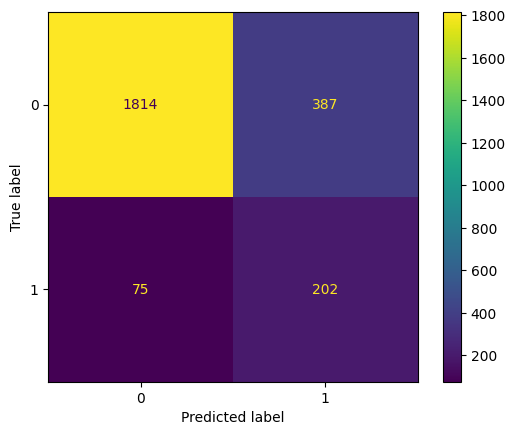

Sensitivity: 0.73
Specificity: 0.82


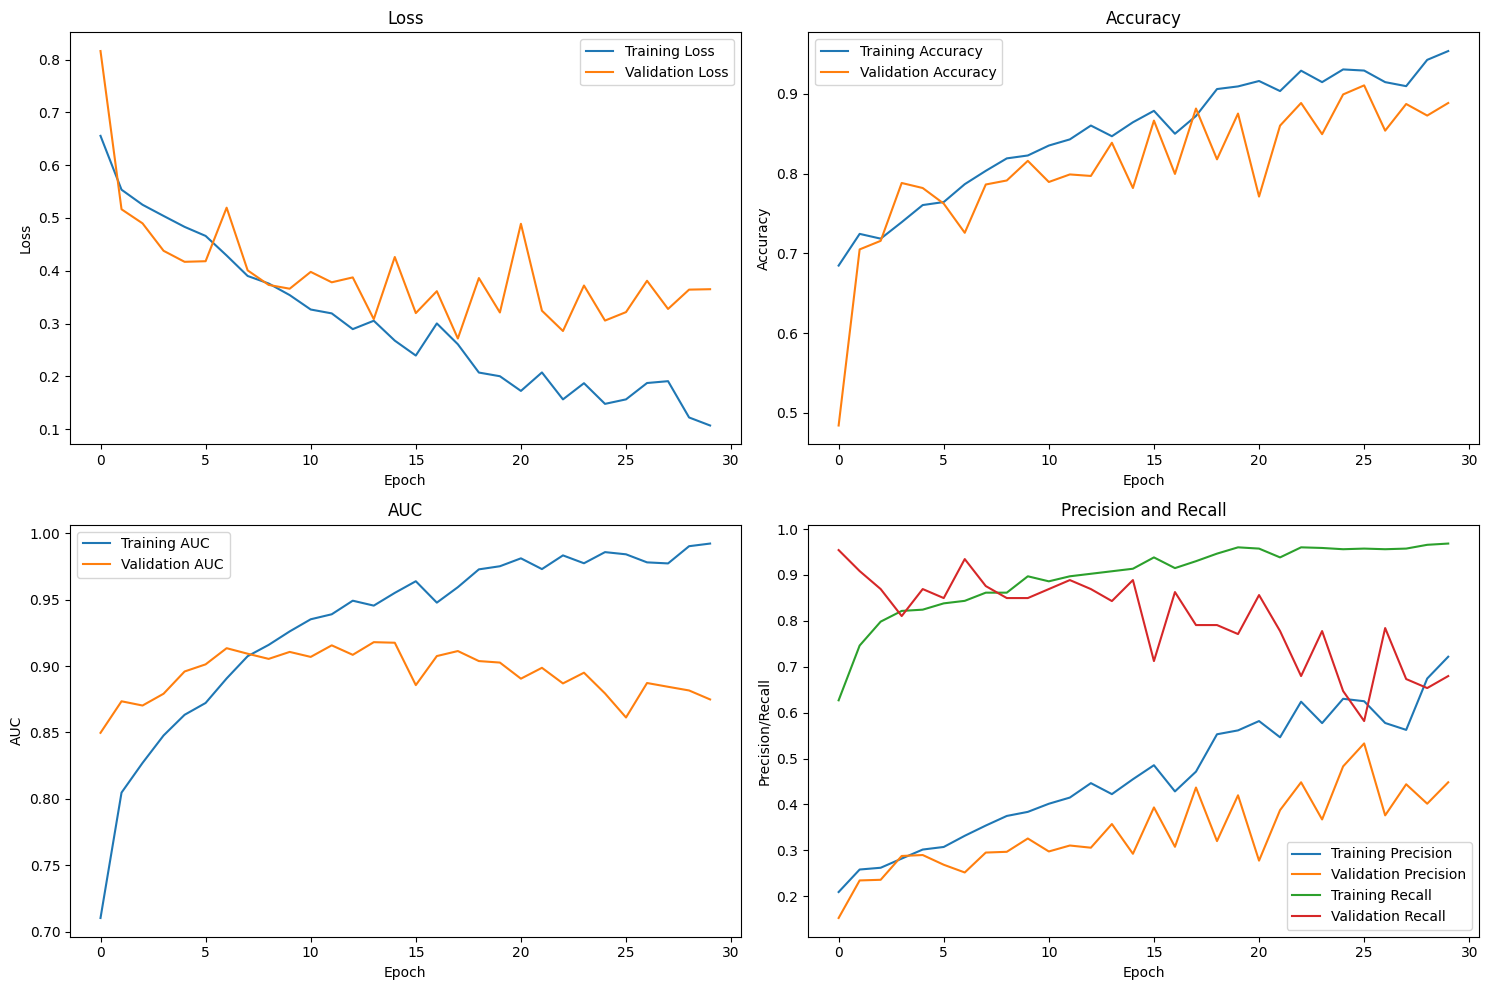

In [ ]:
# Print classification report
print(classification_report(y_test, y_pred_classes))

# Plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Calculate sensitivity, specificity
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")

fig, axes = plt.subplots(2, 2, figsize=(15,10))

# Plot loss
axes[0, 0].plot(out.history['loss'], label='Training Loss')
axes[0, 0].plot(out.history['val_loss'], label='Validation Loss')
axes[0, 0].set_title('Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

# Plot accuracy
axes[0, 1].plot(out.history['accuracy'], label='Training Accuracy')
axes[0, 1].plot(out.history['val_accuracy'], label='Validation Accuracy')
axes[0, 1].set_title('Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

# Plot AUC
axes[1, 0].plot(out.history['auc_2'], label='Training AUC')
axes[1, 0].plot(out.history['val_auc_2'], label='Validation AUC')
axes[1, 0].set_title('AUC')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('AUC')
axes[1, 0].legend()

# Plot precision/recall
axes[1, 1].plot(out.history['precision_2'], label='Training Precision')
axes[1, 1].plot(out.history['val_precision_2'], label='Validation Precision')
axes[1, 1].plot(out.history['recall_2'], label='Training Recall')
axes[1, 1].plot(out.history['val_recall_2'], label='Validation Recall')
axes[1, 1].set_title('Precision and Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Precision/Recall')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

ROC AUC: 0.86


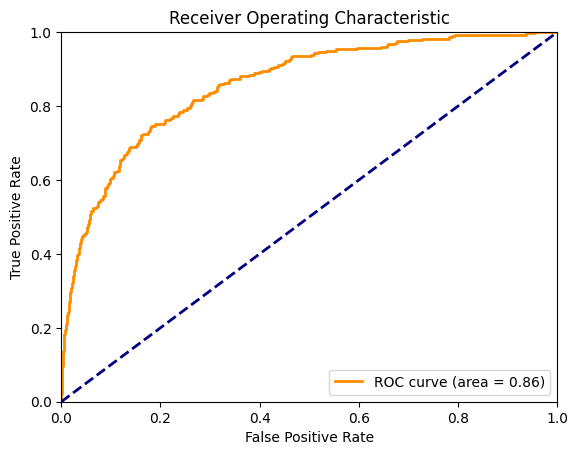

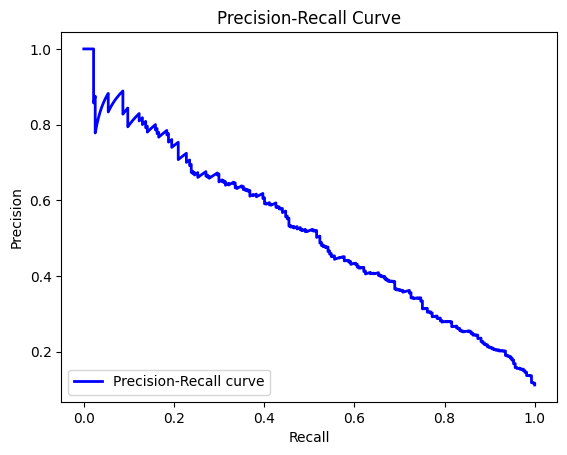

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

print(f"ROC AUC: {roc_auc:.2f}")

# Plot ROC curve
fig1, ax1 = plt.subplots()
ax1.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.0])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operating Characteristic')
ax1.legend(loc="lower right")
plt.show()

# Calculate Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# Plot Precision-Recall curve
fig2, ax2 = plt.subplots()
ax2.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.legend(loc="lower left")
plt.show()

Notes:


*   Balancing the X input data with SMOTE did not affect the accuracy scores.


Considerations:

* Improve specificity!
  * Analyze paper architecture
  * Try 2D CNN
* Should each channel have its own feature map or should they be combined?  
* Explore alternative activation function and pooling layer architectures
* Modify number of convolutional and pooling layers (?)
* Find optimal threshold
* Evaluate more validation metrics







